In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50

from keras.layers.pooling import MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D
from keras.models import Model

In [2]:
BATCH_SIZE = 64
img_height = 224
img_width = 224

In [5]:
train_data_dir = '/kaggle/input/car-train/train'
test_data_dir = '/kaggle/input/car-valid/valid'

# **Resnet**

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
train_generator = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=20, 
                                     brightness_range=[0.1, 1.0],
                                     width_shift_range=0.1, 
                                     height_shift_range=0.1,
                                     horizontal_flip=True, 
                                    #  shear_range = 0.2,
                                     zoom_range = [0.2,1],
                                     preprocessing_function=preprocess_input
                                     ) 

test_generator = ImageDataGenerator(rescale=1.0/255,
                                    preprocessing_function=preprocess_input
                                    )

In [6]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE, )

validgen = test_generator.flow_from_directory(test_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE,)

Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


In [7]:
num_classes = traingen.num_classes
num_classes

196

In [8]:
def res_fine_tune(base_model,num_classes,dropout):
#     base_model.summary()
#     for layer in base_model.layers:
#         layer.trainable = False
    x=base_model.output
    x = AveragePooling2D((5, 5), name='avg_pool')(x)
    x = Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)

    predictions = layers.Dense(num_classes, activation='softmax', name='finalfc')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
#     model.summary()
    return model

In [17]:
HEIGHT = 224
WIDTH = 224

input_shape=(HEIGHT, WIDTH, 3)

lr = 0.0001
dropout = 0.7
epochs = 100

res_base_model = ResNet50(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)

res_model = fine_tune(res_base_model,num_classes,dropout=dropout)
res_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
train_steps = len(traingen.filenames) // BATCH_SIZE
validation_steps = len(validgen.filenames) // BATCH_SIZE

In [15]:
print(train_steps)
print(validation_steps)

101
25


In [18]:
res_history = res_model.fit_generator(generator=traingen,
                                        validation_data=validgen,
                                        steps_per_epoch=train_steps,
                                        epochs=epochs,verbose=2,validation_steps=validation_steps)

Epoch 1/100
101/101 - 129s - loss: 5.3982 - accuracy: 0.0060 - val_loss: 5.4032 - val_accuracy: 0.0050
Epoch 2/100
101/101 - 105s - loss: 5.2619 - accuracy: 0.0074 - val_loss: 5.3264 - val_accuracy: 0.0019
Epoch 3/100
101/101 - 104s - loss: 5.1820 - accuracy: 0.0197 - val_loss: 5.3177 - val_accuracy: 0.0031
Epoch 4/100
101/101 - 105s - loss: 5.0056 - accuracy: 0.0343 - val_loss: 5.2633 - val_accuracy: 0.0088
Epoch 5/100
101/101 - 104s - loss: 4.7326 - accuracy: 0.0623 - val_loss: 5.2156 - val_accuracy: 0.0137
Epoch 6/100
101/101 - 105s - loss: 4.3890 - accuracy: 0.1004 - val_loss: 4.4553 - val_accuracy: 0.0919
Epoch 7/100
101/101 - 105s - loss: 3.9848 - accuracy: 0.1561 - val_loss: 4.2137 - val_accuracy: 0.1213
Epoch 8/100
101/101 - 106s - loss: 3.6041 - accuracy: 0.2082 - val_loss: 3.3565 - val_accuracy: 0.2550
Epoch 9/100
101/101 - 105s - loss: 3.2591 - accuracy: 0.2590 - val_loss: 2.7976 - val_accuracy: 0.3644
Epoch 10/100
101/101 - 104s - loss: 2.9208 - accuracy: 0.3195 - val_loss:

In [19]:
res_model.save('resnet_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
res_validation_score = res_model.evaluate_generator(validgen, steps=validation_steps)
print('Validation loss: ', res_validation_score[0])
print('Validation acc:  ', res_validation_score[1])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation loss:  1.2490828037261963
Validation acc:   0.7124999761581421


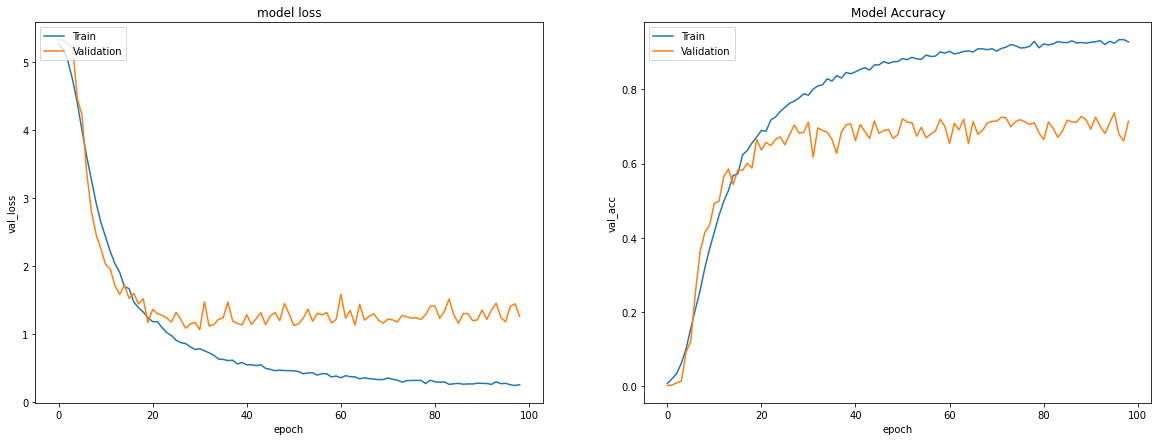

In [23]:
plot_loss_acc(res_history)